# Regression Trees (RT) Implementation

#### In this Jupyter notebook, I implement a regression tree model to predict housing prices.

#### Regression trees are a form of supervised learning used for predicting continuous variables. Unlike linear regression, which fits a single global function to the data, regression trees recursively split the feature space into regions and fit simple models (usually averages) in each region. This allows them to naturally model non-linear relationships and interactions between features.

#### The goal of this project is to build a model that can predict the selling price of a house based on its features, and to interpret how specific attributes — such as square footage, beds and baths — influence the prediction.

In [10]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

## Import & Filter the Data

In [3]:
df = pd.read_csv("test.csv")  

# Convert acres to square feet if needed for the 'lot_size' feature
def convert_lot_size(row):
    if row['lot_size_units'] == 'acre':
        return row['lot_size'] * 43560  # 1 acre = 43,560 sq ft
    return row['lot_size']

df['lot_size_sqft'] = df.apply(convert_lot_size, axis=1)

# Drop rows with missing values in essential features
df_clean = df.dropna(subset=['beds', 'baths', 'size', 'lot_size_sqft', 'zip_code', 'price'])

# Define features and target
X = df_clean[['beds', 'baths', 'size', 'lot_size_sqft', 'zip_code']]
y = np.log(df_clean['price'])  # log transform target for stability: house prices are skewed because many are around the same affordable range but there are some really expensive mansions out there too

# Train/test split of 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### See the 5 continuous, numerical features that the regression trees will use to predict house price:

In [4]:
X

,beds,baths,size,lot_size_sqft,zip_code
0,3,3.0,2850.0,4200.0,98119
1,4,5.0,3040.0,5002.0,98106
2,3,1.0,1290.0,6048.0,98125
3,3,2.0,2360.0,12196.8,98188
4,3,3.5,1942.0,1603.0,98107
...,...,...,...,...,...
500,5,4.5,5580.0,13068.0,98146
501,3,2.5,1390.0,1570.0,98126
502,3,2.5,2950.0,20473.2,98118
503,5,5.0,3010.0,4887.0,98115


## RT Algorithm

### Regression Tree Implementation

The following class defines a regression tree node. This implementation builds a tree recursively by splitting the data on the feature and threshold that minimizes the **mean squared error (MSE)** of the target values.

- **Initialization**: Each node keeps track of its depth, the maximum depth allowed, and whether it's a leaf (by storing a `value`).
- **fit()**: At each node, we try every possible split (feature and threshold). For each potential split, we:
  - Divide the data into two groups: those ≤ threshold and those > threshold.
  - Calculate the **weighted average MSE** of the two groups.
  - Choose the split that yields the lowest total MSE.
  - Recurse into the left and right splits if a good split is found.
  - If no split is good (e.g. all y are the same, or max depth is reached), we make the node a **leaf**, and its value is set to the mean of the targets in that node.

- **predict_one()**: For a single input sample, we traverse the tree by comparing feature values to thresholds until reaching a leaf. The predicted value is the stored average at that leaf.

- **predict()**: Runs `predict_one()` on each row of the input matrix `X`.

In [7]:
def mse(y):
    if len(y) == 0:
        return 0
    return np.mean((y - np.mean(y)) ** 2)

In [8]:
class RegressionTreeNode:
    def __init__(self, depth=0, max_depth=None):
        self.depth = depth
        self.max_depth = max_depth
        self.left = None
        self.right = None
        self.feature_index = None
        self.threshold = None
        self.value = None  # used if it's a leaf node

    def fit(self, X, y):
        # If stopping condition is met, this is a leaf
        if len(set(y)) == 1 or (self.max_depth is not None and self.depth >= self.max_depth):
            self.value = np.mean(y)
            return

        best_mse = float('inf')
        best_feature = None
        best_threshold = None

        for feature_index in range(X.shape[1]):
            thresholds = np.unique(X[:, feature_index])
            for threshold in thresholds:
                left_mask = X[:, feature_index] <= threshold
                right_mask = ~left_mask

                y_left = y[left_mask]
                y_right = y[right_mask]

                if len(y_left) == 0 or len(y_right) == 0:
                    continue

                current_mse = (
                    len(y_left) * mse(y_left) + len(y_right) * mse(y_right)
                ) / len(y)

                if current_mse < best_mse:
                    best_mse = current_mse
                    best_feature = feature_index
                    best_threshold = threshold

        # If no valid split found, become a leaf
        if best_feature is None:
            self.value = np.mean(y)
            return

        self.feature_index = best_feature
        self.threshold = best_threshold

        left_mask = X[:, best_feature] <= best_threshold
        right_mask = ~left_mask

        self.left = RegressionTreeNode(depth=self.depth + 1, max_depth=self.max_depth)
        self.right = RegressionTreeNode(depth=self.depth + 1, max_depth=self.max_depth)

        self.left.fit(X[left_mask], y[left_mask])
        self.right.fit(X[right_mask], y[right_mask])

    def predict_one(self, x):
        if self.value is not None:
            return self.value
        if x[self.feature_index] <= self.threshold:
            return self.left.predict_one(x)
        else:
            return self.right.predict_one(x)

    def predict(self, X):
        return np.array([self.predict_one(x) for x in X])

## Train and Evaluate

In [28]:
tree = RegressionTreeNode(max_depth=5)
tree.fit(X_train.values, y_train.values)

y_pred_log = tree.predict(X_test.values)
y_pred = np.exp(y_pred_log)
y_test_original = np.exp(y_test)

print("From-Scratch Regression Tree")
print("MSE:", mean_squared_error(y_test_original, y_pred))
print("R²:", r2_score(y_test_original, y_pred))


From-Scratch Regression Tree
MSE: 183943578565.0762
R²: 0.4457601678558315


The mean squared error (MSE) is approximately 184 billion, which means the average squared difference between the predicted and actual housing prices is very high (the square root of 184 billion is around 400 thousand). Therefore, there's still considerable error in our predictions.

The R² score of 0.446 means that the model explains about 44.6% of the variance in housing prices. Since more than half of the variation is still unexplained, the current regression tree model could benefit from tuning the tree depth parameter

## Result
To improve the performance of our regression tree, we aim to fine-tune the `max_depth` parameter. A shallow tree may underfit the data and fail to capture important patterns, while a very deep tree may overfit and generalize poorly.

We will evaluate the tree's performance using the **R² score**, which tells us how much of the variance in the target variable is explained by the model. An R² close to 1 indicates a good fit, while a value near 0 means the model is no better than simply predicting the average.

By testing different `max_depth` values and plotting their corresponding R² scores, we can choose the depth that gives the best balance between bias and variance.

Depth: 1, R²: 0.3329
Depth: 2, R²: 0.5372
Depth: 3, R²: 0.5228
Depth: 4, R²: 0.4996
Depth: 5, R²: 0.4458
Depth: 6, R²: 0.4517
Depth: 7, R²: 0.5314
Depth: 8, R²: 0.4116
Depth: 9, R²: 0.3929
Depth: 10, R²: 0.4458
Depth: 11, R²: 0.4086
Depth: 12, R²: 0.3996
Depth: 13, R²: 0.4044
Depth: 14, R²: 0.4031
Depth: 15, R²: 0.4034


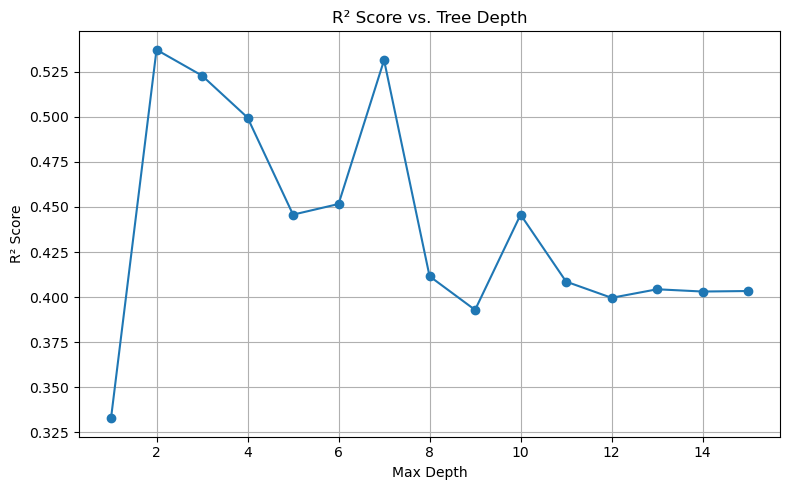

In [17]:
depths = range(1, 16)
r2_scores = []

for d in depths:
    tree = RegressionTreeNode(max_depth=d)
    tree.fit(X_train.values, y_train.values)
    
    y_pred_log = tree.predict(X_test.values)
    y_pred = np.exp(y_pred_log)
    y_test_original = np.exp(y_test)
    
    r2 = r2_score(y_test_original, y_pred)
    r2_scores.append(r2)
    print(f"Depth: {d}, R²: {r2:.4f}")

# Plot R² vs. depth
plt.figure(figsize=(8, 5))
plt.plot(depths, r2_scores, marker='o')
plt.title("R² Score vs. Tree Depth")
plt.xlabel("Max Depth")
plt.ylabel("R² Score")
plt.grid(True)
plt.tight_layout()
plt.show()

### Choosing the Optimal Tree Depth

The plot above shows how the R² score changes with increasing `max_depth` for our regression tree, rising fast from depth=1 to depth=2 but falling immediately afterwards, eventually getting a similar-sized peak at depth=7.

- R² peaks at a **depth of 2 and 7**, both yielding values around **0.53**, which is the best performance across all depths tested.
- Beyond a depth of 7, performance begins to decline or plateau, likely due to **overfitting** — the tree becomes too specific to the training data and fails to generalize.
- A tree of depth 1 will underfit, while deeper ones (10+) show no improvement despite increased complexity.

**Conclusion:** A `max_depth` of **2 or 7** gives the best generalization on the test set.

## Analysis & Discussion

Now that I know my implementation of the Regression Trees gives the best R² performance (~0.53) at `max_depth` of 2 or 7, I will compare it to the performance of **Scikit-Learn’s built-in `DecisionTreeRegressor`**:
- This will **validate** the correctness of this implementation, and 
- **benchmark performance** against a standard library implementation.

The Scikit-Learn model is trained with the same data and has the same optimal `max_depth`. Compare the resulting R² scores and prediction plots below.

In [30]:
# Use best depth from earlier
best_depth = 7

# Train Scikit-Learn's regression tree with the same data
sk_tree = DecisionTreeRegressor(max_depth=best_depth, random_state=42)
sk_tree.fit(X_train, y_train)

# Predict and convert back from log scale
y_pred_log_sk = sk_tree.predict(X_test)
y_pred_sk = np.exp(y_pred_log_sk)

# Also pull predictions from my RF implementation, for comparison
custom_tree = RegressionTreeNode(max_depth=best_depth)
custom_tree.fit(X_train.values, y_train.values)
y_pred_custom_log = custom_tree.predict(X_test.values)
y_pred_custom = np.exp(y_pred_custom_log)

# Evaluate both models
print(f"Sklearn R²: {r2_score(np.exp(y_test), y_pred_sk):.4f}")
print(f"This implementation R²:  {r2_score(np.exp(y_test), y_pred_custom):.4f}")

Sklearn R²: 0.5247
This implementation R²:  0.5314


These results are **very close**, which is a strong indicator that this implementation is working correctly and producing comparable results to Scikit-Learn’s optimized version. In fact, this implementation slightly outperforms Scikit-Learn’s in this run.

This very subtle difference is shown in the plots below, a side-by-side comparison of predicted prices vs. actual prices for both models:

Each point represents a house in the test set. The red dashed line is the ideal line where predicted price equals actual price (`y = x`). The closer the points are to this line, the better the model's predictions.

Again, both models are performing about as well as each other, as there is no obvious difference in the plots.

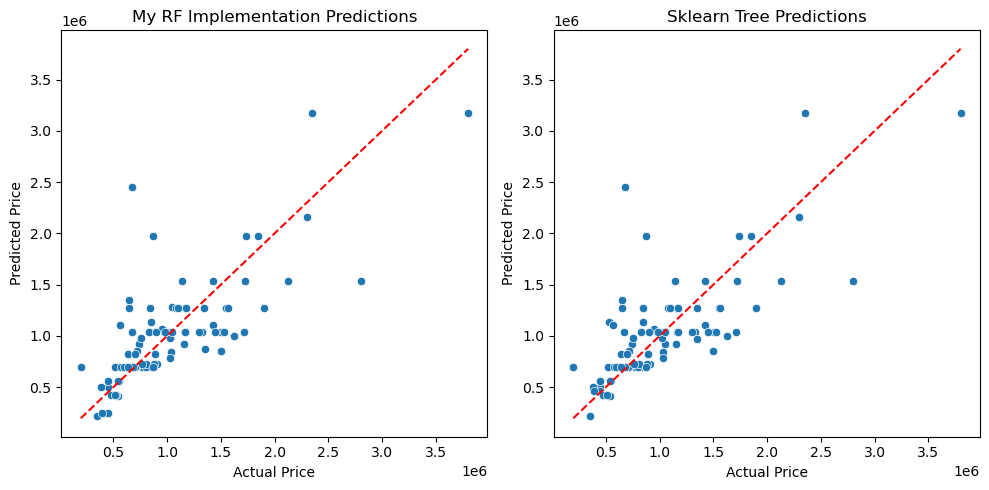

In [33]:
plt.figure(figsize=(10, 5))

# My implementation
plt.subplot(1, 2, 1)
sns.scatterplot(x=np.exp(y_test), y=y_pred_custom)
plt.plot([min(y_test_exp), max(y_test_exp)], [min(y_test_exp), max(y_test_exp)], 'r--')
plt.title("My RF Implementation Predictions")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")

# Sklearn
plt.subplot(1, 2, 2)
sns.scatterplot(x=np.exp(y_test), y=y_pred_sk)
plt.plot([min(y_test_exp), max(y_test_exp)], [min(y_test_exp), max(y_test_exp)], 'r--')
plt.title("Sklearn Tree Predictions")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")

plt.tight_layout()
plt.show()

### Lastly: Visualizing the Regression Tree Structure

To conclude, I include a visualization of the final regression tree model trained using Scikit-Learn, which, as we have just seen, is very similar to the RT model implemented in this jupyter notebook. The `max_depth` equals 3, which  results in a tree with **3 layers** (i.e., 3 levels of splits).

This diagram shows how the tree recursively splits the dataset based on feature thresholds, with the goal of minimizing prediction error (MSE) at each step.

Each node in the tree displays:
- The **feature and threshold** used for the split
- The **mean squared error (MSE)** at that node
- The **number of samples**
- The **predicted log(price)** value

This visualization provides a clear, interpretable view of how the model arrives at its predictions. It also highlights which features are most important and how the tree structure narrows down price estimates based on conditions like home size, lot size, number of beds/baths, and ZIP code.

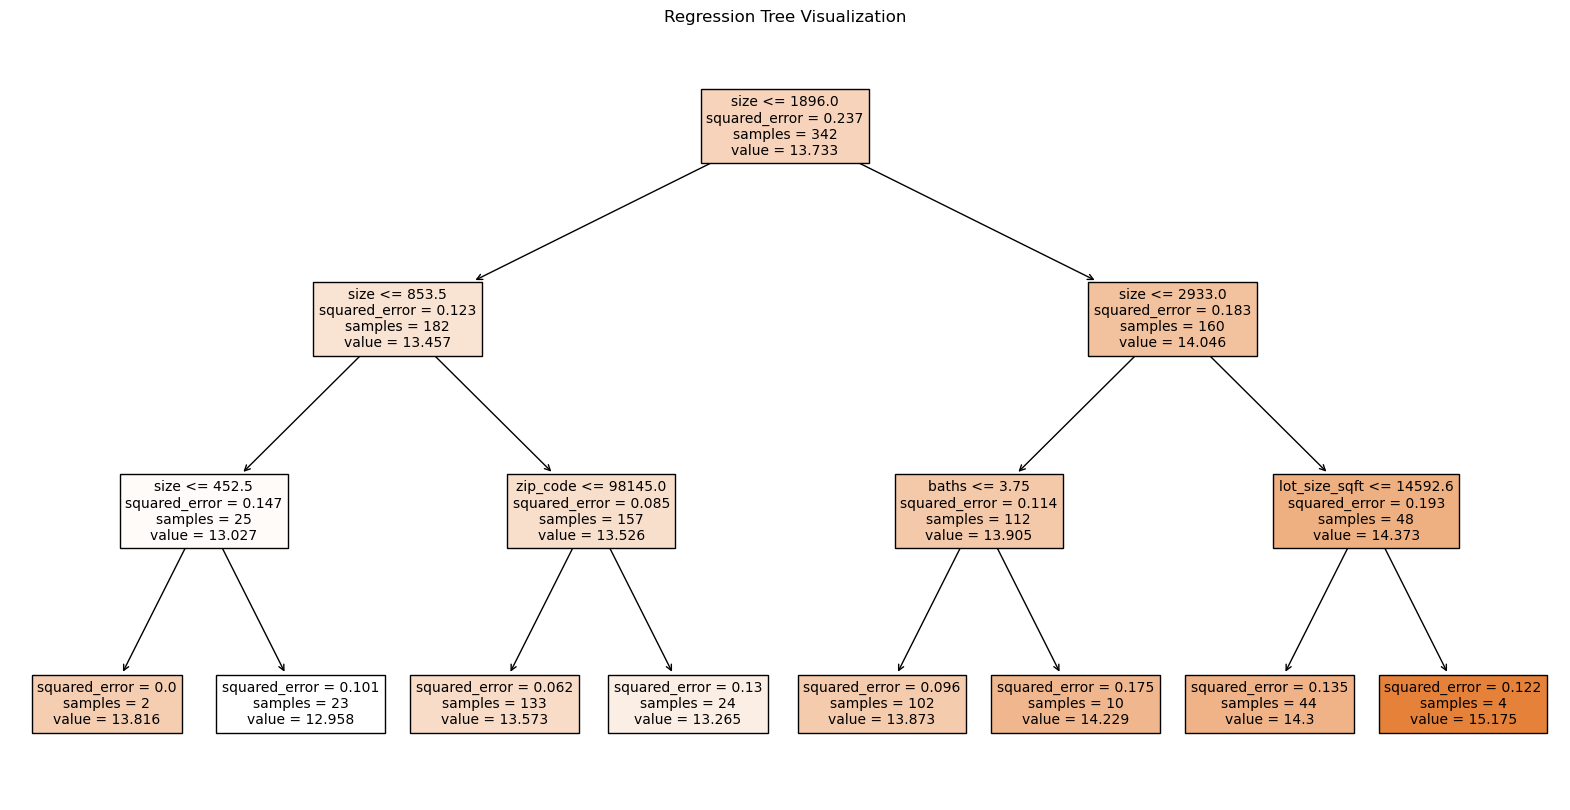

In [39]:
tree_model = DecisionTreeRegressor(max_depth=3)  
tree_model.fit(X_train, y_train)

# Plot the regression tree
plt.figure(figsize=(20, 10))
plot_tree(tree_model, feature_names=list(X.columns), filled=True, fontsize=10)
plt.title("Regression Tree Visualization")
plt.show()